In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# 1. Load the dataset

In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/mydataset/filtered_attacks (1).csv')
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# 2. Feature Engineering: Creating new specific features

In [3]:
# 1. Feature Engineering: Creating new specific features
# These features are designed to capture differences in protocol behavior and traffic flow
df['Fwd_Bwd_Pkts_Ratio'] = df['Total Fwd Packets'] / (df['Total Backward Packets'] + 1)
df['Total_Bytes'] = df['Total Length of Fwd Packets'] + df['Total Length of Bwd Packets']
df['Header_to_Data_Ratio'] = (df['Fwd Header Length'] + df['Bwd Header Length']) / (df['Total_Bytes'] + 1)
df['Bwd_to_Fwd_Bytes_Ratio'] = df['Total Length of Bwd Packets'] / (df['Total Length of Fwd Packets'] + 1)
df['Flow_IAT_Range'] = df['Flow IAT Max'] - df['Flow IAT Min']
df['Avg_IAT'] = df['Flow Duration'] / (df['Total Fwd Packets'] + df['Total Backward Packets'] + 1)
df['Packet_Size_Spread'] = df['Max Packet Length'] - df['Min Packet Length']

# 2. Preparation for Evaluation
# Dropping duplicates and balancing for a fair assessment
df_clean = df.drop_duplicates(subset=[c for c in df.columns if c != 'Label'])
df_balanced = df_clean.groupby('Label').apply(lambda x: x.sample(n=min(len(x), 1900), random_state=42)).reset_index(drop=True)

/tmp/ipykernel_54/4072032389.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_clean.groupby('Label').apply(lambda x: x.sample(n=min(len(x), 1900), random_state=42)).reset_index(drop=True)


# K-Means:

Importance of newly engineered features:
Total_Bytes               0.028664
Header_to_Data_Ratio      0.024856
Bwd_to_Fwd_Bytes_Ratio    0.024610
Avg_IAT                   0.021237
Fwd_Bwd_Pkts_Ratio        0.014688
Flow_IAT_Range            0.013044
Packet_Size_Spread        0.012644
dtype: float64

Final Cluster Distribution with Engineered Features:
Cluster_Engineered     0     1     2     3     4     5     6     7     8     9
Label                                                                         
BENIGN                29  1452    26    19   125    51    72    29    80    17
Bot                    0     4     0     0  1896     0     0     0     0     0
DDoS                   0     0     0  1896     3     0     1     0     0     0
DoS GoldenEye          1    21     0     0     0     0     0  1878     0     0
DoS Hulk               1     5     0     0     0     0  1643     5     0     1
DoS Slowhttptest     184     1     0     0     0     0     1    13     1  1700
DoS slowloris

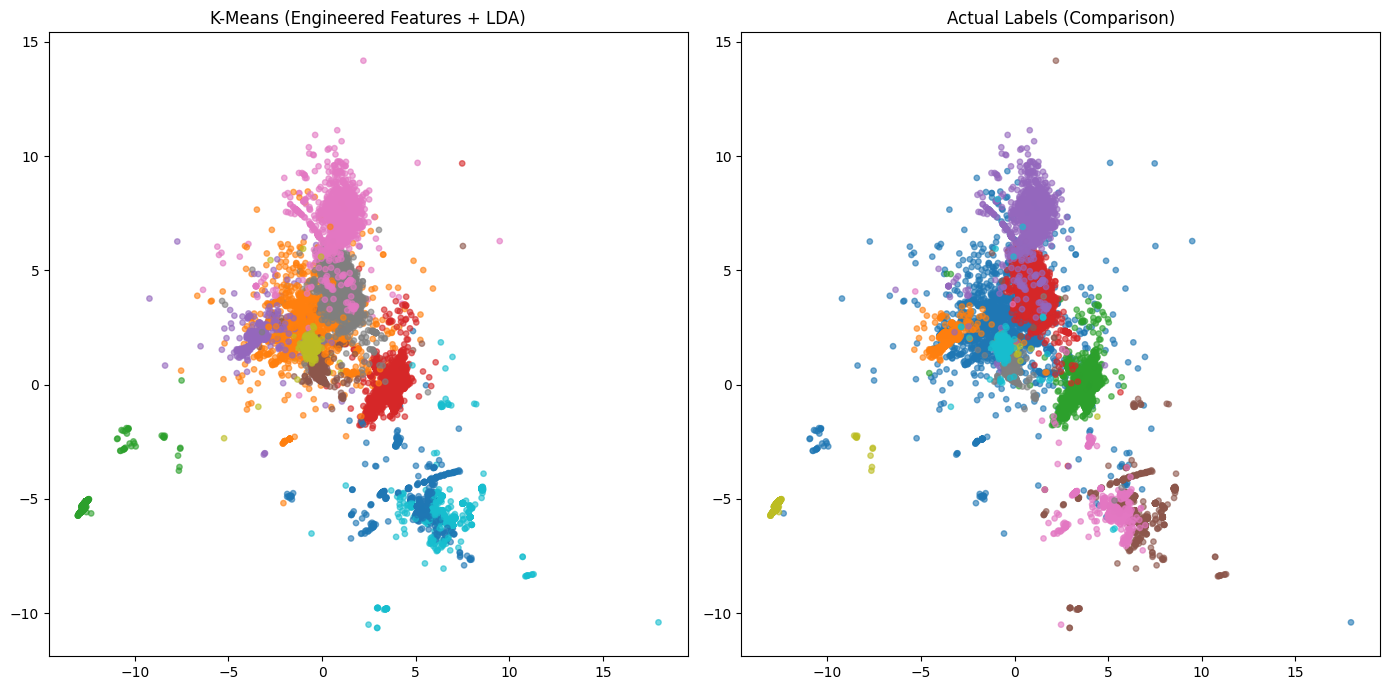

In [4]:


X = df_balanced.drop(columns=['Label'])
if 'Destination Port' in X.columns:
    X = X.drop(columns=['Destination Port'])
y = df_balanced['Label']

# 3. Check Importance of New Features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

new_features = ['Fwd_Bwd_Pkts_Ratio', 'Total_Bytes', 'Header_to_Data_Ratio', 'Bwd_to_Fwd_Bytes_Ratio', 'Flow_IAT_Range', 'Avg_IAT', 'Packet_Size_Spread']
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("Importance of newly engineered features:")
print(importances[new_features].sort_values(ascending=False))

# 4. Clustering with Engineered Features
# Use PowerTransformer on the full set of features (including new ones)
pt = PowerTransformer(method='yeo-johnson')
X_transformed = pt.fit_transform(X)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_transformed)

# LDA to maximize class separation based on all features (including the new ones)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=9)
X_lda = lda.fit_transform(X_scaled, y)

kmeans = KMeans(n_clusters=10, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_lda)

# 5. Result Analysis
df_balanced['Cluster_Engineered'] = clusters
cluster_dist = pd.crosstab(df_balanced['Label'], df_balanced['Cluster_Engineered'])

# PCA for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_lda)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.6, s=15)
plt.title('K-Means (Engineered Features + LDA)')

plt.subplot(1, 2, 2)
label_mapping = {label: i for i, label in enumerate(df_balanced['Label'].unique())}
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_balanced['Label'].map(label_mapping), cmap='tab10', alpha=0.6, s=15)
plt.title('Actual Labels (Comparison)')
plt.tight_layout()
plt.savefig('engineered_feature_clustering.png')

print("\nFinal Cluster Distribution with Engineered Features:")
print(cluster_dist)